In [1]:
from latency_data import convolve_data_from_file
from latency_data import get_train_data
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_crossentropy
import keras
import pydot
import graphviz
import matplotlib.pyplot as plt
from collections import deque
import random

In [2]:
data_file_num = 1000 # Max 8999
directory_on = "training_data/gpu_on/"
directory_off = "training_data/gpu_off/"
window = 1000
overlap = 200

samples_on = get_train_data(
    data_file_num, directory_on, "train", window, overlap)
samples_off = get_train_data(
    data_file_num, directory_off, "train", window, overlap)

In [3]:
len(samples_on[9])

47

In [4]:
samples_on

[array([149.35228329, 283.03267428, 205.67740196, 111.18367281,
        326.06811813,  57.03748486,  59.2928714 ,  72.04545776,
        191.6846172 , 185.03159211,  37.36465055,  47.48755188,
         48.74086479,  29.15161016,  46.10603913,  45.07227756,
         54.47218335,  63.98854598,  51.33436446,  47.11790483,
         47.61673954,  56.0016374 ,  49.15532846,  25.44937247,
         45.33067834,  49.72494762,  29.91743771,  45.99651687,
         28.54200131,  44.35329864,  45.79705745,  52.91844574,
         46.44620958,  47.53098522,  46.97007541,  45.73637798,
         26.13738656,  50.05843941,  46.30174916,  36.43308078,
         48.59377866,  46.72493124,  47.00642271,  59.81714162,
         56.78747675,  49.27076244,  58.41106326]),
 array([298.04965908, 266.01843616, 311.63729987, 129.8695421 ,
        286.6618329 ,  52.58810223,  52.4458452 , 222.45753618,
        247.32183549,  67.75193723,  45.95103389,  58.5223955 ,
         60.6130702 ,  47.02779621,  39.76467164,  4

In [5]:
min_allowable_data_length = 0

samples_on = [i for i in samples_on if len(i) >= min_allowable_data_length]
samples_off = [i for i in samples_off if len(i) >= min_allowable_data_length]

In [6]:
#train_samples = np.append(samples_on, samples_off)

In [7]:
min_data_length = 1000
for i in range(len(samples_on)):
    min_data_length = len(samples_on[i]) if len(samples_on[i]) < min_data_length else min_data_length
for i in range(len(samples_off)):
    min_data_length = len(samples_off[i]) if len(samples_off[i]) < min_data_length else min_data_length
print(min_data_length)

47


In [8]:
train_samples = samples_on[0][:min_data_length]
for i in range(1, len(samples_on)):
    train_samples = np.vstack([train_samples, np.array(samples_on[i][:min_data_length])])
for i in range(0, len(samples_off)):
    train_samples = np.vstack([train_samples, np.array(samples_off[i][:min_data_length])])

In [9]:
average_rotation = 0
    
for i in range(len(samples_on)):
    deq = deque(samples_on[i])
    rotation = random.randint(0, len(samples_on[i]))
    deq.rotate(rotation)
    average_rotation = average_rotation + rotation
    samples_on[i] = list(deq)
for i in range(len(samples_off)):
    deq = deque(samples_off[i])
    rotation = random.randint(-len(samples_off[i]), len(samples_off[i]))
    deq.rotate(rotation)
    average_rotation = average_rotation + rotation
    samples_off[i] = list(deq)

print(average_rotation / (len(samples_on) + len(samples_off)))

12.1395


In [10]:
train_labels = np.append(np.ones(len(samples_off)), np.zeros(len(samples_on)))

In [11]:
print(train_samples.shape)
print(train_labels.shape)

(2000, 47)
(2000,)


In [12]:
x_train = train_samples
y_train = train_labels

In [13]:
print(x_train[x_train != 0.0])

[149.35228329 283.03267428 205.67740196 ...  53.27053219  62.97163068
  59.9140511 ]


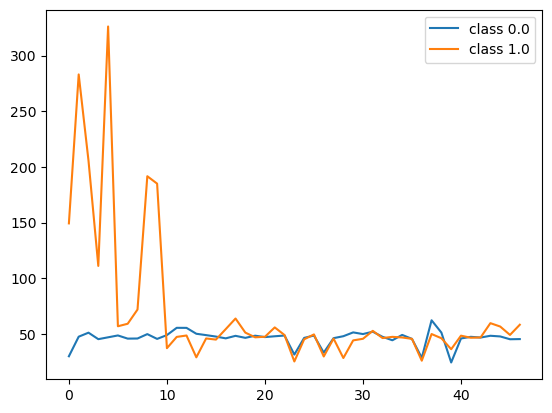

In [14]:
classes = np.unique(y_train)

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

In [15]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2000, 47, 1)

In [16]:
num_classes = len(np.unique(y_train))
num_classes

2

In [17]:
#idx = np.random.permutation(len(x_train))

In [18]:
#x_train = x_train[idx]
#y_train = y_train[idx]

In [19]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    
    dense1 = keras.layers.Dense(4)(input_layer)
    gap = keras.layers.GlobalAveragePooling1D()(dense1)
    
    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 47, 1)]           0         
                                                                 
 dense (Dense)               (None, 47, 4)             8         
                                                                 
 global_average_pooling1d (G  (None, 4)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


In [21]:
epochs = 500
batch_size = 50

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.000001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
32/32 [==============================] - 1s 7ms/step - loss: 15.3150 - sparse_categorical_accuracy: 0.3750 - val_loss: 2.8287e-05 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 2/500
32/32 [==============================] - 0s 2ms/step - loss: 5.7483 - sparse_categorical_accuracy: 0.3750 - val_loss: 0.4271 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0010
Epoch 3/500
32/32 [==============================] - 0s 2ms/step - loss: 0.7385 - sparse_categorical_accuracy: 0.6087 - val_loss: 1.4633 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/500
32/32 [==============================] - 0s 2ms/step - loss: 0.6330 - sparse_categorical_accuracy: 0.6250 - val_loss: 1.1639 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/500
32/32 [==============================] - 0s 2ms/step - loss: 0.6247 - sparse_categorical_accuracy: 0.6250 - val_loss: 1.1463 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/500
32/32 [====

32/32 [==============================] - 0s 2ms/step - loss: 0.5176 - sparse_categorical_accuracy: 0.6250 - val_loss: 0.8837 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 2.5000e-04
Epoch 43/500
32/32 [==============================] - 0s 2ms/step - loss: 0.5161 - sparse_categorical_accuracy: 0.6250 - val_loss: 0.9415 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 2.5000e-04
Epoch 44/500
32/32 [==============================] - 0s 2ms/step - loss: 0.5154 - sparse_categorical_accuracy: 0.6250 - val_loss: 0.9094 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 2.5000e-04
Epoch 45/500
32/32 [==============================] - 0s 2ms/step - loss: 0.5138 - sparse_categorical_accuracy: 0.6250 - val_loss: 0.8938 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 2.5000e-04
Epoch 46/500
32/32 [==============================] - 0s 2ms/step - loss: 0.5124 - sparse_categorical_accuracy: 0.6250 - val_loss: 0.8992 - val_sparse_categorical_accuracy: 0.0000e+00 - lr: 2.5000e-04
Epoch 47

In [22]:
model = keras.models.load_model("best_model.h5")

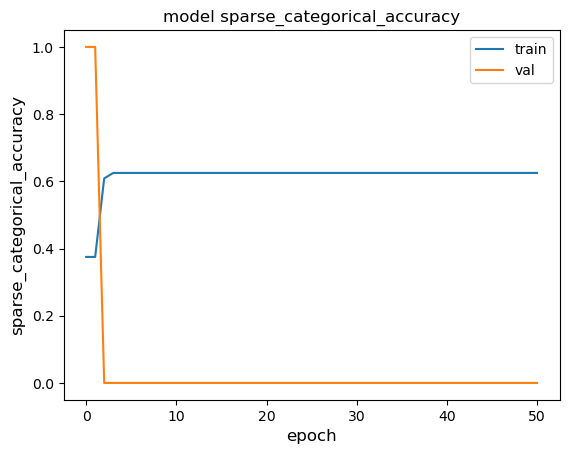

In [23]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()